In [75]:
import os
import numpy as np
from PIL import Image
import shutil
import matplotlib.pyplot as plt
from itertools import compress
from skimage.util.shape import view_as_windows
import cv2
import time
%matplotlib inline

In [2]:
def rename_files_to_numerical(folder_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    files.sort()

    for i, filename in enumerate(files):
        new_filename = f"{i}.png"
        old_file_path = os.path.join(folder_path, filename)
        new_file_path = os.path.join(output_path, new_filename)
        
        # Copy the file to the new location with the new name
        shutil.copyfile(old_file_path, new_file_path)
        print(f"Copied and renamed: {old_file_path} to {new_file_path}")

In [3]:
folder_path = '../seismic_images/prepare_numpy/seismic/'
output_path = '../seismic_images/prepare_numpy/seismic/edit'
rename_files_to_numerical(folder_path, output_path)

None
Copied and renamed: ../seismic_images/prepare_numpy/seismic/IL2800.png to ../seismic_images/prepare_numpy/seismic/edit\0.png
Copied and renamed: ../seismic_images/prepare_numpy/seismic/IL2900.png to ../seismic_images/prepare_numpy/seismic/edit\1.png
Copied and renamed: ../seismic_images/prepare_numpy/seismic/IL3000.png to ../seismic_images/prepare_numpy/seismic/edit\2.png
Copied and renamed: ../seismic_images/prepare_numpy/seismic/IL3100.png to ../seismic_images/prepare_numpy/seismic/edit\3.png
Copied and renamed: ../seismic_images/prepare_numpy/seismic/IL3200.png to ../seismic_images/prepare_numpy/seismic/edit\4.png
Copied and renamed: ../seismic_images/prepare_numpy/seismic/IL3300.png to ../seismic_images/prepare_numpy/seismic/edit\5.png
Copied and renamed: ../seismic_images/prepare_numpy/seismic/IL3400.png to ../seismic_images/prepare_numpy/seismic/edit\6.png
Copied and renamed: ../seismic_images/prepare_numpy/seismic/IL3500.png to ../seismic_images/prepare_numpy/seismic/edit\7

In [4]:
folder_path = '../seismic_images/prepare_numpy/label/'
output_path = '../seismic_images/prepare_numpy/label/edit'
rename_files_to_numerical(folder_path, output_path)

None
Copied and renamed: ../seismic_images/prepare_numpy/label/IL2800_fault.png to ../seismic_images/prepare_numpy/label/edit\0.png
Copied and renamed: ../seismic_images/prepare_numpy/label/IL2900_fault.png to ../seismic_images/prepare_numpy/label/edit\1.png
Copied and renamed: ../seismic_images/prepare_numpy/label/IL3000_fault.png to ../seismic_images/prepare_numpy/label/edit\2.png
Copied and renamed: ../seismic_images/prepare_numpy/label/IL3100_fault.png to ../seismic_images/prepare_numpy/label/edit\3.png
Copied and renamed: ../seismic_images/prepare_numpy/label/IL3200_fault.png to ../seismic_images/prepare_numpy/label/edit\4.png
Copied and renamed: ../seismic_images/prepare_numpy/label/IL3300_fault.png to ../seismic_images/prepare_numpy/label/edit\5.png
Copied and renamed: ../seismic_images/prepare_numpy/label/IL3400_fault.png to ../seismic_images/prepare_numpy/label/edit\6.png
Copied and renamed: ../seismic_images/prepare_numpy/label/IL3500_fault.png to ../seismic_images/prepare_nu

In [12]:
def load_and_concatenate_png_files(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    files.sort(key=lambda x: int(os.path.splitext(x)[0]))  # Sort numerically by filename

    images = []
    for filename in files:
        file_path = os.path.join(folder_path, filename)
        with Image.open(file_path) as img:
            img_array = np.array(img)
            images.append(img_array)
    
    concatenated_images = np.stack(images, axis=0)
    
    return concatenated_images


In [16]:
seis_path = '../seismic_images/prepare_numpy/seismic/edit'
seismic = load_and_concatenate_png_files(seis_path)

print(f"Concatenated images shape: {seismic.shape}")

Concatenated images shape: (63, 860, 1341)


In [17]:
print(seismic.min())
print(seismic.max())

seismic = (seismic - seismic.min()) / (seismic.max() - seismic.min()) # min-max normalization
seismic.min(), seismic.max()

22
255


(0.0, 1.0)

In [18]:
save_path = '../seismic_images/prepare_numpy/seismic/edit/wisting_seismic.npy'
np.save(save_path, seismic)

In [20]:
seismic_image = np.load(save_path)
seismic_image.shape
seismic_image.max()

1.0

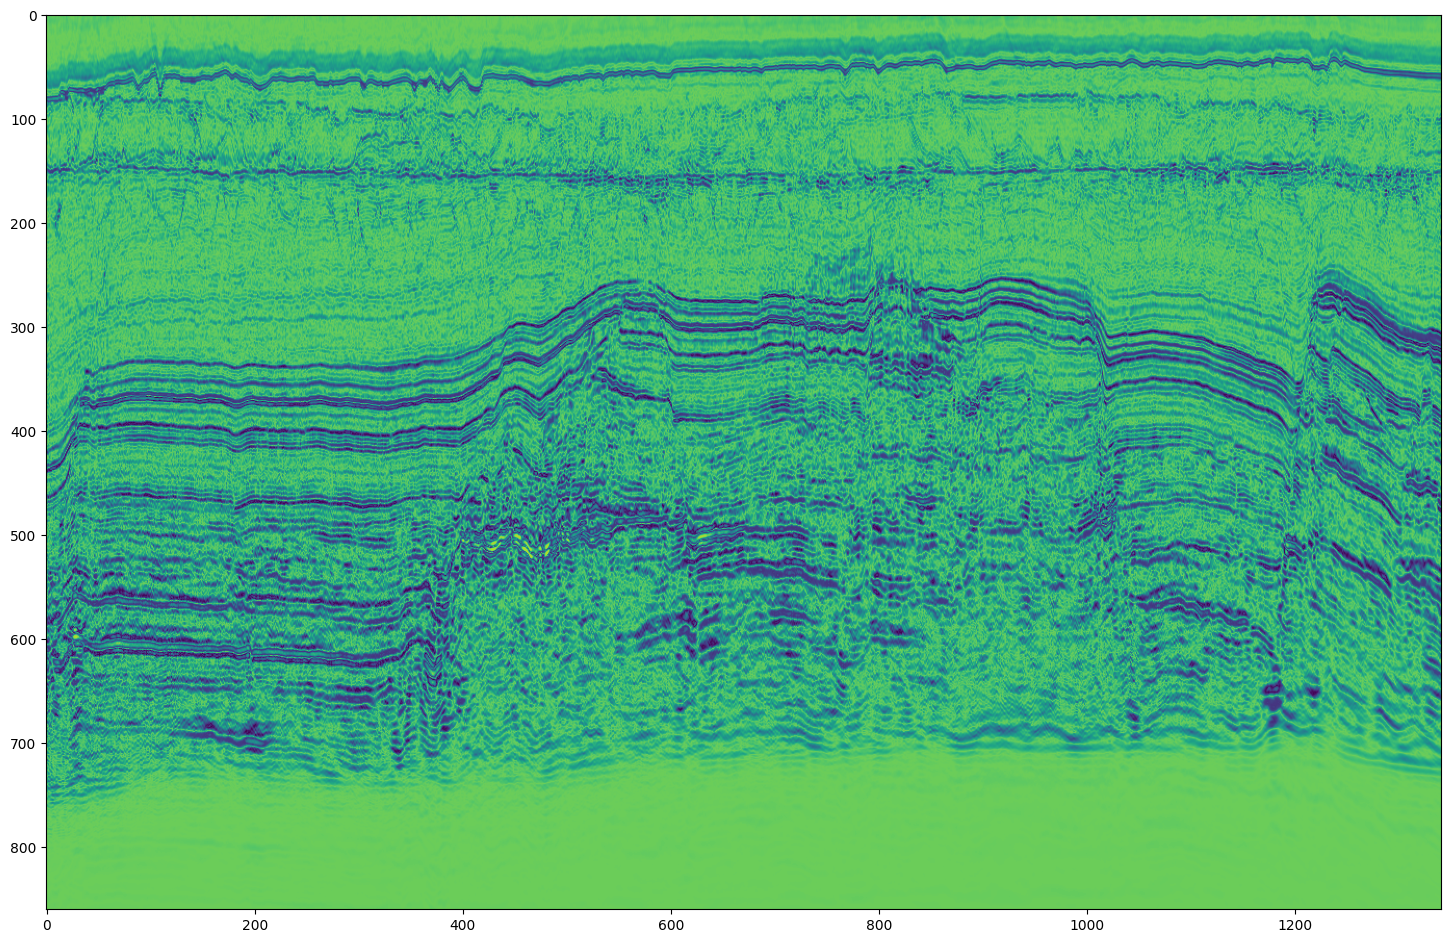

In [35]:
plt.figure(figsize=(18,18))
plt.imshow(seismic_image[2,:,:])
plt.show()

load fault label, stack them in one file and apply normalization

In [21]:
label_path = '../seismic_images/prepare_numpy/label/edit'
label = load_and_concatenate_png_files(label_path)

print(f"Concatenated images shape: {label.shape}")

Concatenated images shape: (63, 860, 1341)


In [22]:
print(label.min(),label.max())

22 255


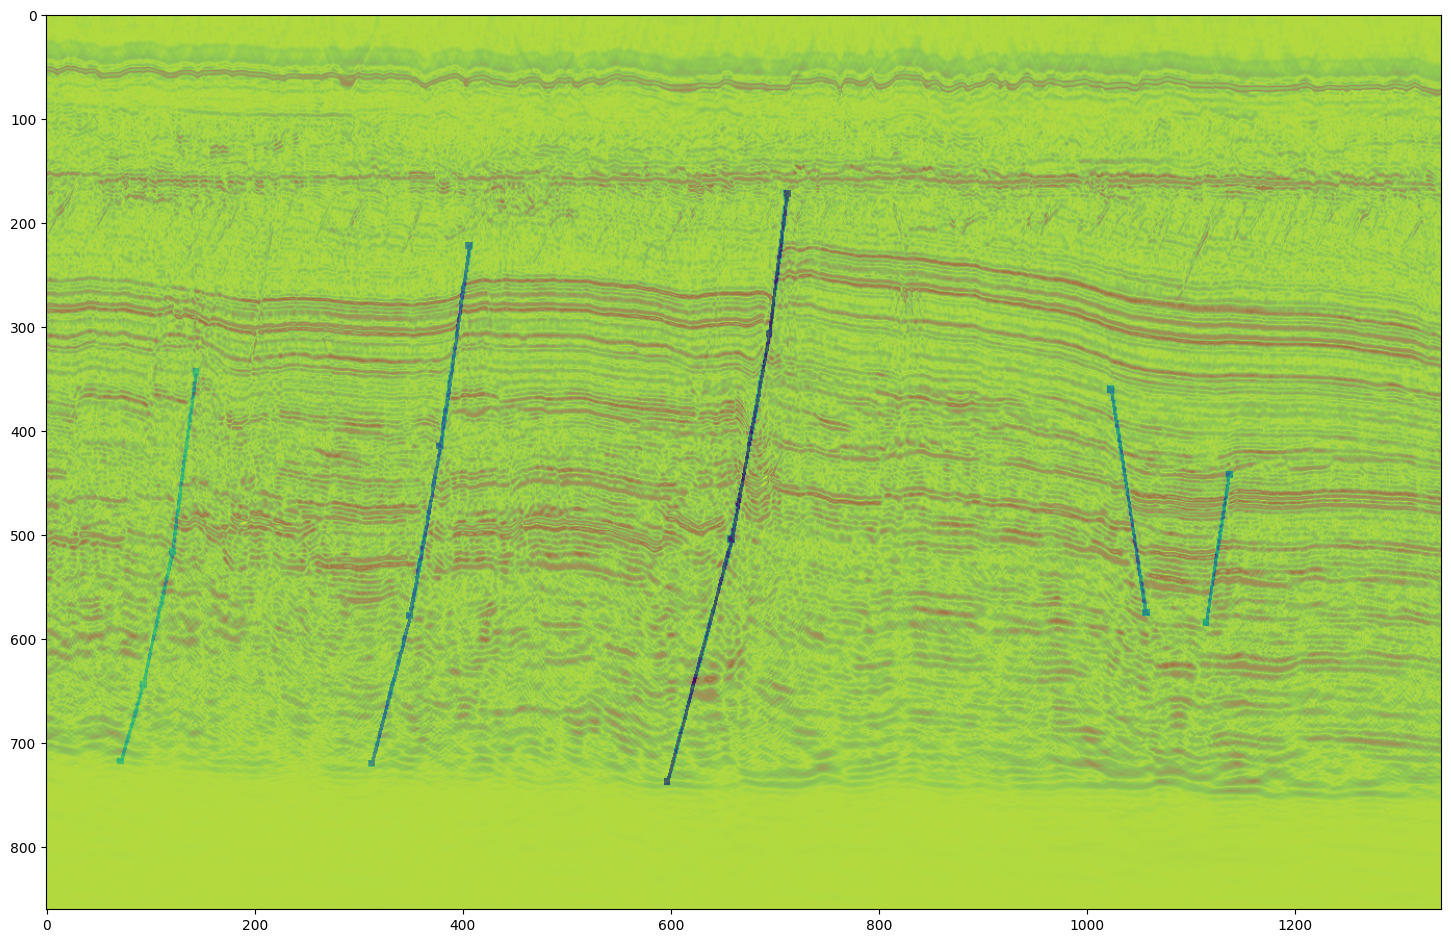

In [59]:
plt.figure(figsize=(18,18))
plt.imshow(seismic_image[45])
plt.imshow(label[45],alpha=0.5)
plt.show()

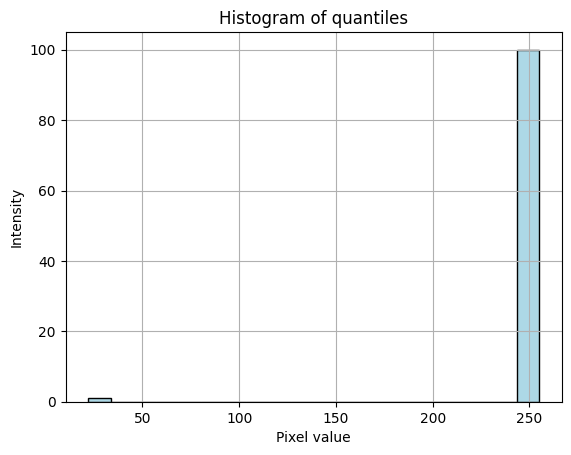

In [99]:
quantiles = np.quantile(label, np.linspace(0, 1, 101))
plt.hist(quantiles, bins=20, color='lightblue', edgecolor='black')
plt.title('Histogram of quantiles')
plt.xlabel('Pixel value')
plt.ylabel('Intensity')
plt.grid()
plt.show()

In [106]:
threshold = np.quantile(label, q=0.3)
fault = np.where(label<threshold, 255, 0)

In [107]:
print(fault.min(),fault.max()) # in a pixel range (0,255)

fault = fault.astype(np.float32) / 255.0
fault.min(), fault.max()

0 255


(0.0, 1.0)

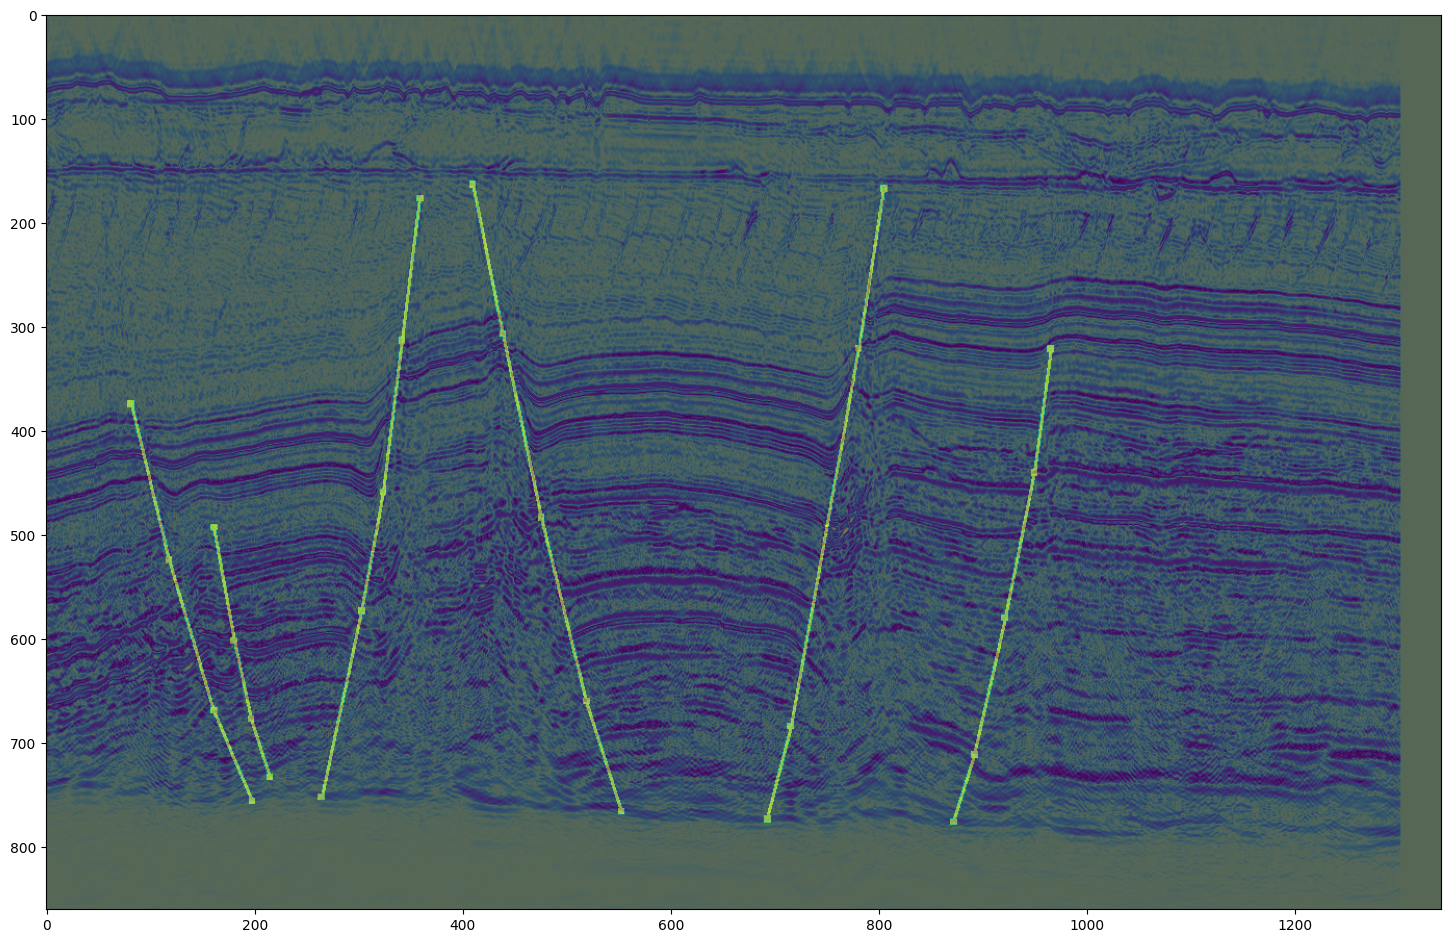

In [110]:
# QC the seismic and labels 

plt.figure(figsize=(18,18))
plt.imshow(seismic_image[62])
plt.imshow(fault[62],alpha=0.5)
plt.show()

In [61]:
save_path = '../seismic_images/prepare_numpy/label/edit/wisting_fault.npy'
np.save(save_path, fault)

In [63]:
label_image = np.load(save_path)
print(label_image.shape)
label_image.min(),label_image.max()

(63, 860, 1341)


(0.0, 1.0)

Patches prepare

In [64]:
print(seismic.shape)
print(fault.shape)

(63, 860, 1341)
(63, 860, 1341)


In [67]:
IL, Z, XL = fault.shape

im_height = Z
im_width = XL
splitsize = 96
stepsize = 48
overlapsize = splitsize-stepsize
pixelThre = int(0.03*splitsize*splitsize)
print(pixelThre)

276


In [68]:
horizontal_splits_number = int(np.ceil((im_width-overlapsize)/stepsize))
print("horizontal_splits_number", horizontal_splits_number)
width_after_pad = stepsize*horizontal_splits_number+overlapsize
print("width_after_pad", width_after_pad)
left_pad = int((width_after_pad-im_width)/2)
right_pad = width_after_pad-im_width-left_pad
print("left_pad,right_pad",left_pad,right_pad)

vertical_splits_number = int(np.ceil((im_height-overlapsize)/stepsize))
print("vertical_splits_number",vertical_splits_number)
height_after_pad = stepsize*vertical_splits_number+overlapsize
print("height_after_pad",height_after_pad)
top_pad = int((height_after_pad-im_height)/2)
bottom_pad = height_after_pad-im_height-top_pad
print("top_pad,bottom_pad", top_pad,bottom_pad)

horizontal_splits_number 27
width_after_pad 1344
left_pad,right_pad 1 2
vertical_splits_number 17
height_after_pad 864
top_pad,bottom_pad 2 2


In [69]:
def split_Image(bigImage,isMask,top_pad,bottom_pad,left_pad,right_pad,splitsize,stepsize,vertical_splits_number,horizontal_splits_number):
#     print(bigImage.shape)
    if isMask==True:
        arr = np.pad(bigImage,((top_pad,bottom_pad),(left_pad,right_pad)),"reflect")
        splits = view_as_windows(arr, (splitsize,splitsize),step=stepsize)
        splits = splits.reshape((vertical_splits_number*horizontal_splits_number,splitsize,splitsize))
    else: 
        arr = np.pad(bigImage,((top_pad,bottom_pad),(left_pad,right_pad),(0,0)),"reflect")
        splits = view_as_windows(arr, (splitsize,splitsize,3),step=stepsize)
        splits = splits.reshape((vertical_splits_number*horizontal_splits_number,splitsize,splitsize,3))
    return splits # return list of arrays.

In [77]:
t_start = time.time()
X = []
Y = []
for i in range(0,63,1):
    mask = fault[i]
    splits = split_Image(mask, True,top_pad,bottom_pad,left_pad,right_pad,splitsize,stepsize,vertical_splits_number,horizontal_splits_number)
#     print(splits.shape)
    t = (splits.sum((1,2)) < pixelThre)
    no_label_element_index = list(compress(range(len(t)), t))
    # get all the indexes of the no label pieces by adding elements in axis 2 and 3.
    splits = np.delete(splits, no_label_element_index,0) # delete element i along axis 0
#     print("splits.shape", splits.shape)
    Y.extend(splits)
    
    img = seismic[i]
    splits = split_Image(img, True,top_pad,bottom_pad,left_pad,right_pad,splitsize,stepsize,vertical_splits_number,horizontal_splits_number)
    splits = np.delete(splits, no_label_element_index,0) # delete element i along axis 0
#     print("splits.shape", splits.shape)
    X.extend(splits)
#     break

print(len(Y))
print(len(X))
print(X[0].shape)
print("read images in {} sec".format(time.time()-t_start))

5598
5598
(96, 96)
read images in 1.9598424434661865 sec


In [78]:
X = np.asarray(X, dtype=np.float32)
Y = np.asarray(Y, dtype=np.float32)

In [79]:
directory = '../seismic_images/prepare_numpy/seis_patch'
if not os.path.exists(directory):
    os.makedirs(directory)
directory = '../seismic_images/prepare_numpy/fault_patch'
if not os.path.exists(directory):
    os.makedirs(directory)

In [80]:
patches_path = '../seismic_images/prepare_numpy/'

for i in range(len(X)):
    np.save('{}/seis_patch/{}.npy'.format(patches_path, i),X[i])
    np.save('{}/fault_patch/{}.npy'.format(patches_path, i),Y[i])

stack the patches 

In [81]:
def numerical_sort(file_list):
    return sorted(file_list, key=lambda x: int(''.join(filter(str.isdigit, x))))

def concatenate_and_save(folder_path, output_directory, output_file):
    files = os.listdir(folder_path)
    sorted_file_list = numerical_sort(files)
    print(sorted_file_list)

    np_files = [f for f in sorted_file_list if f.endswith('.npy')]
    arrays = [np.load(os.path.join(folder_path, f)) for f in np_files]
    concatenated_array = np.stack(arrays)
    
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    output_path = os.path.join(output_directory, output_file)
    np.save(output_path, concatenated_array)
    
    print("Stacked array shape:", concatenated_array.shape)
    print("Concatenation complete. Array saved as", output_path)

In [82]:
time_start = time.time()
folder_path = '../seismic_images/prepare_numpy/seis_patch'
output_directory = '../seismic_images/prepare_numpy/'
output_file = 'wisting_seis.npy'
concatenate_and_save(folder_path, output_directory, output_file)
time_end = (time.time() -time_start)/60
print(f'Time spent: {time_end} mins')

['0.npy', '1.npy', '2.npy', '3.npy', '4.npy', '5.npy', '6.npy', '7.npy', '8.npy', '9.npy', '10.npy', '11.npy', '12.npy', '13.npy', '14.npy', '15.npy', '16.npy', '17.npy', '18.npy', '19.npy', '20.npy', '21.npy', '22.npy', '23.npy', '24.npy', '25.npy', '26.npy', '27.npy', '28.npy', '29.npy', '30.npy', '31.npy', '32.npy', '33.npy', '34.npy', '35.npy', '36.npy', '37.npy', '38.npy', '39.npy', '40.npy', '41.npy', '42.npy', '43.npy', '44.npy', '45.npy', '46.npy', '47.npy', '48.npy', '49.npy', '50.npy', '51.npy', '52.npy', '53.npy', '54.npy', '55.npy', '56.npy', '57.npy', '58.npy', '59.npy', '60.npy', '61.npy', '62.npy', '63.npy', '64.npy', '65.npy', '66.npy', '67.npy', '68.npy', '69.npy', '70.npy', '71.npy', '72.npy', '73.npy', '74.npy', '75.npy', '76.npy', '77.npy', '78.npy', '79.npy', '80.npy', '81.npy', '82.npy', '83.npy', '84.npy', '85.npy', '86.npy', '87.npy', '88.npy', '89.npy', '90.npy', '91.npy', '92.npy', '93.npy', '94.npy', '95.npy', '96.npy', '97.npy', '98.npy', '99.npy', '100.npy'

In [83]:
time_start = time.time()
folder_path = '../seismic_images/prepare_numpy/fault_patch'
output_directory = '../seismic_images/prepare_numpy/'
output_file = 'wisting_fault.npy'
concatenate_and_save(folder_path, output_directory, output_file)
time_end = (time.time() -time_start)/60
print(f'Time spent: {time_end} mins')

['0.npy', '1.npy', '2.npy', '3.npy', '4.npy', '5.npy', '6.npy', '7.npy', '8.npy', '9.npy', '10.npy', '11.npy', '12.npy', '13.npy', '14.npy', '15.npy', '16.npy', '17.npy', '18.npy', '19.npy', '20.npy', '21.npy', '22.npy', '23.npy', '24.npy', '25.npy', '26.npy', '27.npy', '28.npy', '29.npy', '30.npy', '31.npy', '32.npy', '33.npy', '34.npy', '35.npy', '36.npy', '37.npy', '38.npy', '39.npy', '40.npy', '41.npy', '42.npy', '43.npy', '44.npy', '45.npy', '46.npy', '47.npy', '48.npy', '49.npy', '50.npy', '51.npy', '52.npy', '53.npy', '54.npy', '55.npy', '56.npy', '57.npy', '58.npy', '59.npy', '60.npy', '61.npy', '62.npy', '63.npy', '64.npy', '65.npy', '66.npy', '67.npy', '68.npy', '69.npy', '70.npy', '71.npy', '72.npy', '73.npy', '74.npy', '75.npy', '76.npy', '77.npy', '78.npy', '79.npy', '80.npy', '81.npy', '82.npy', '83.npy', '84.npy', '85.npy', '86.npy', '87.npy', '88.npy', '89.npy', '90.npy', '91.npy', '92.npy', '93.npy', '94.npy', '95.npy', '96.npy', '97.npy', '98.npy', '99.npy', '100.npy'

In [85]:
wisting_seis = np.load('../seismic_images/prepare_numpy/wisting_patch/seis_test.npy')

wisting_fault = np.load('../seismic_images/prepare_numpy/wisting_patch/fault_test.npy')

In [87]:
wisting_seis.shape, wisting_fault.shape

((5598, 96, 96), (5598, 96, 96))

In [97]:
def plot_random_images(images, labels, num_images=4):
    # Select random indices
    num_total_images = len(images)
    random_indices = np.random.choice(num_total_images, size=num_images, replace=False)
    
    fig, axes = plt.subplots(3, num_images, figsize=(18, 10))
    
    # Plot overlapped images
    for i, idx in enumerate(random_indices):
        axes[0, i].imshow(images[idx], cmap='gray', aspect='auto')
        axes[0, i].axis('off')
        axes[0, i].set_title(f"seismic id: {idx}")
        axes[0, i].imshow(labels[idx], cmap='gray', aspect='auto',alpha=0.3)
        
    # Plot labels
    for i, idx in enumerate(random_indices):
        axes[1, i].imshow(labels[idx],cmap='gray', aspect='auto')
        axes[1, i].set_title(f"label id: {idx}")
        axes[1, i].axis('off')
    
    # Plot original images
    for i, idx in enumerate(random_indices):
        axes[2, i].imshow(images[idx], cmap='gray', aspect='auto')
        axes[2, i].axis('off')
        axes[2, i].set_title(f"original seismic: {idx}")
        
    
    plt.tight_layout()
    plt.show()

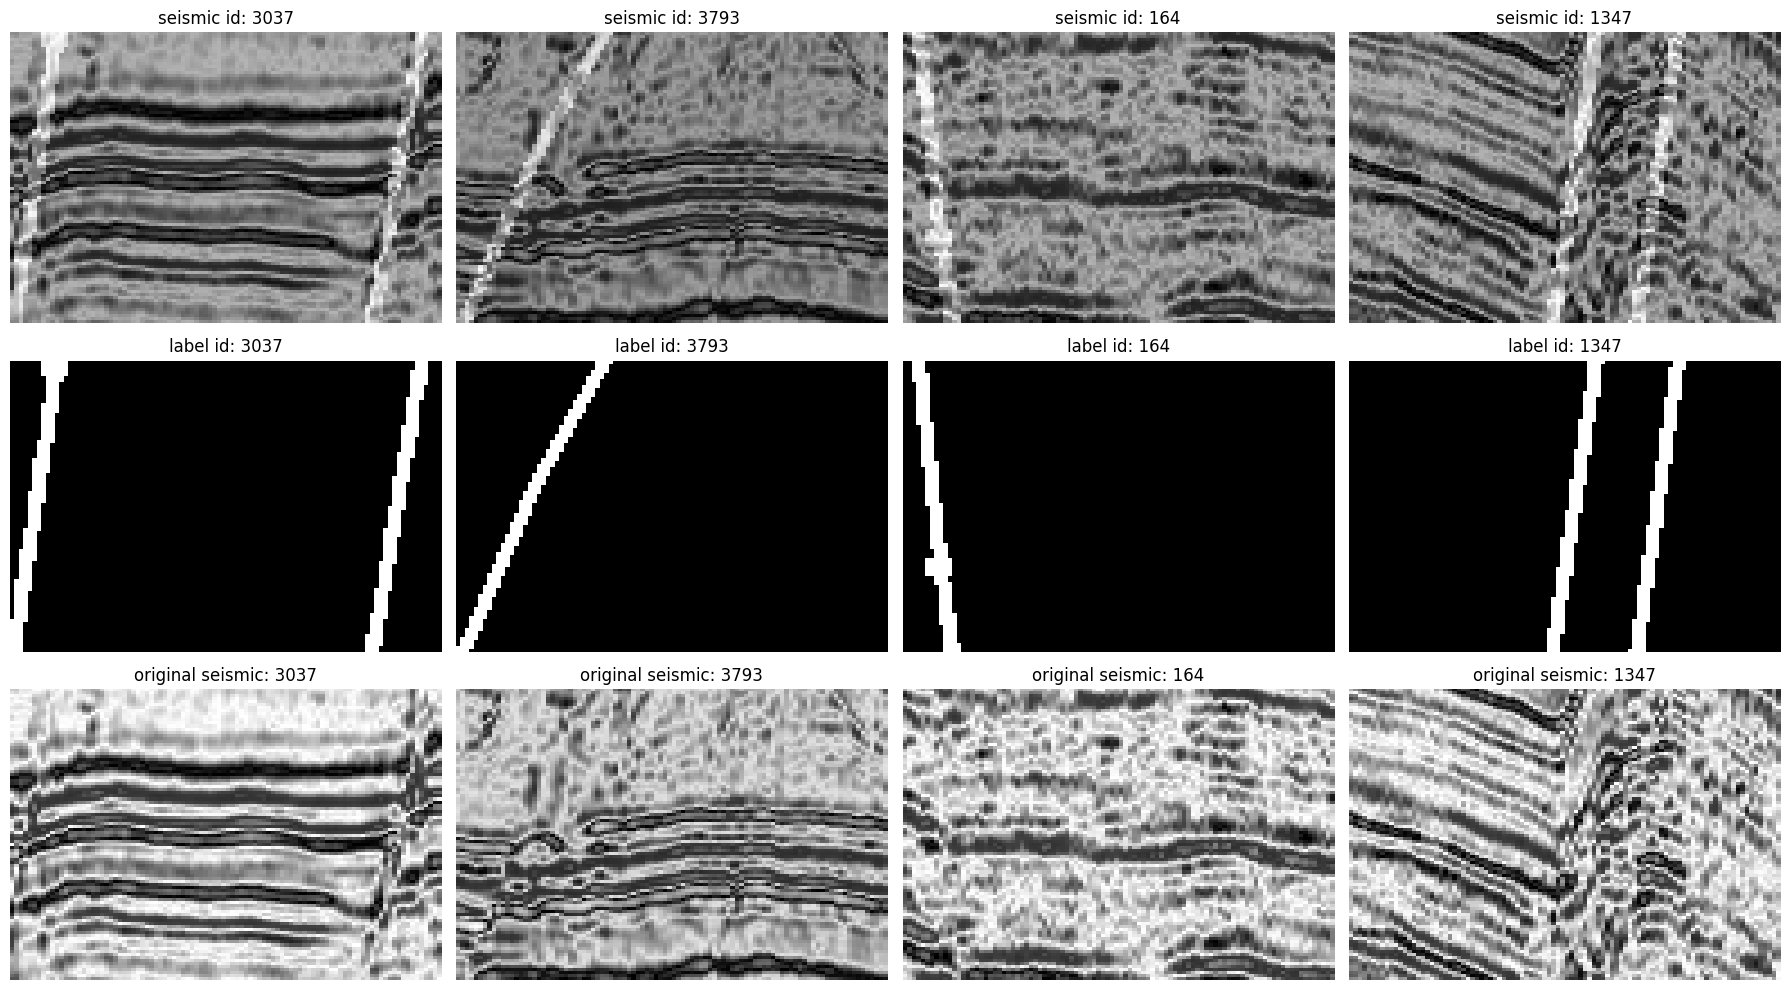

In [98]:
plot_random_images(wisting_seis,wisting_fault,num_images=4)